In [1]:
import fitz
import cv2
import csv
import imutils
import numpy as np
import matplotlib.pyplot as plt
import pytesseract

In [55]:
pdf_document = "/Users/alejandra/Documents/GitHub/CranberryLab/External_structure/PDF/Stamp_photos/pagina_1.pdf"
doc = fitz.open(pdf_document)
for page_number in range(doc.page_count):
    page = doc[page_number]
    pix = page.get_pixmap()
    pix.save(f"page_{page_number + 1}.png")


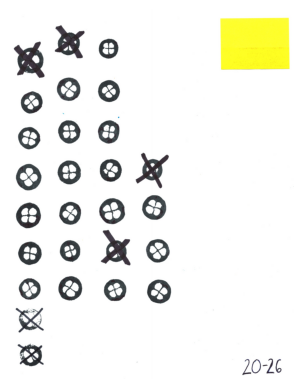

In [113]:
# Read image
img = cv2.imread('/Users/alejandra/Documents/GitHub/CranberryLab/External_structure/PDF/Stamp_photos/JPG/pagina_1.jpg') #BGR image
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Gray image
rgb_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # RGB image

# Look our image
plt.imshow(rgb_image)
plt.axis('off')
plt.show()


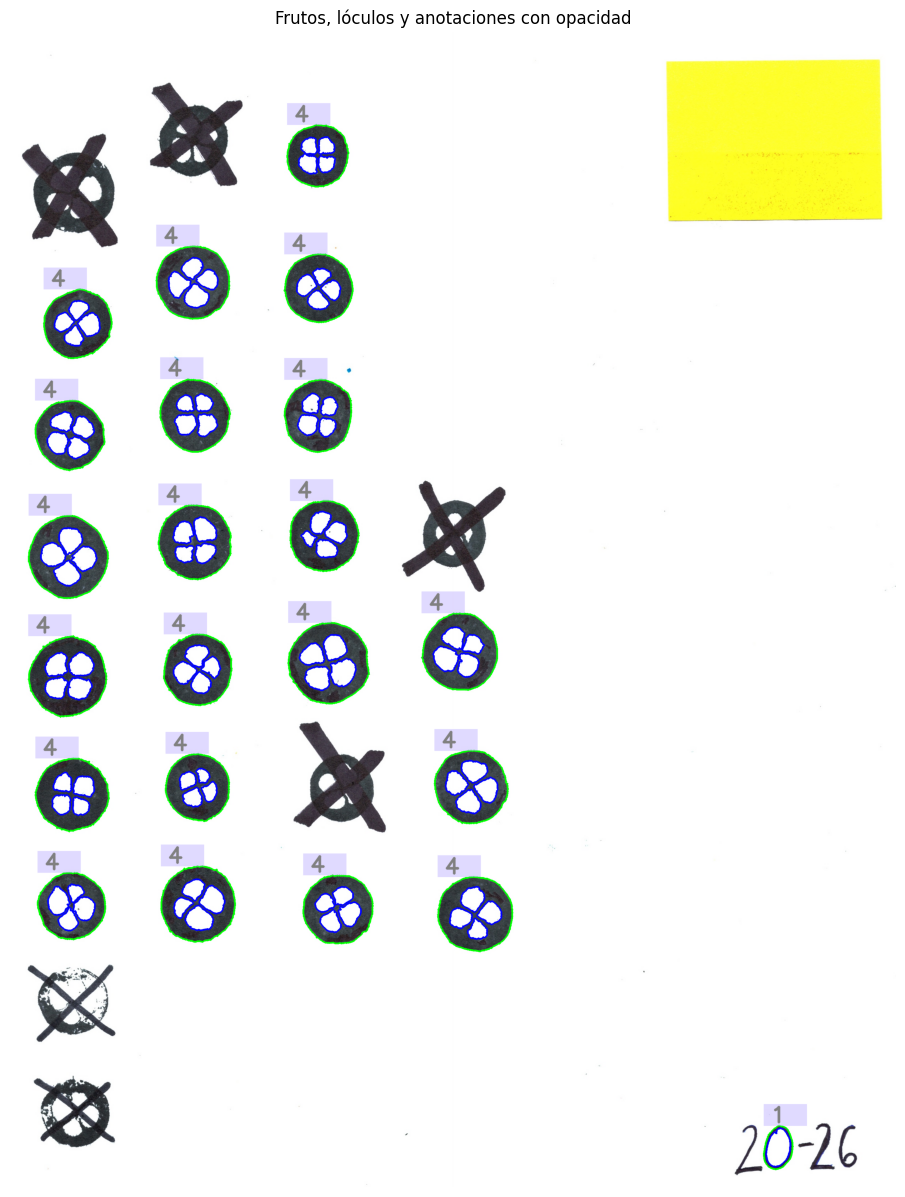

In [95]:

# Aplicar umbral para binarizar la imagen
_, binary = cv2.threshold(gray_img, 150, 255, cv2.THRESH_BINARY_INV)

# Aplicar cierre morfológico para rellenar huecos pequeños
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))  # Ajusta según los huecos
closed_binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

# Encontrar contornos en la imagen cerrada
contours, hierarchy = cv2.findContours(closed_binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Crear una máscara vacía para rellenar contornos
filled_mask = np.zeros_like(closed_binary)

# Dibujar contornos rellenos
cv2.drawContours(filled_mask, contours, -1, (255), thickness=-1)

# Filtrar contornos padres basados en circularidad
def is_contour_bad(c, min_area=500, min_circularity=0.6, max_circularity=1.2):
    area = cv2.contourArea(c)
    perimeter = cv2.arcLength(c, True)
    if perimeter == 0:
        return True
    circularity = 4 * np.pi * (area / (perimeter * perimeter))
    return area < min_area or not (min_circularity <= circularity <= max_circularity)

filtered_contours = [
    i for i in range(len(contours))
    if hierarchy[0][i][3] == -1 and not is_contour_bad(contours[i])
]

# Detectar frutos y sus lóculos
fruit_locus_map = {}
for i in filtered_contours:
    fruit_locus_map[i] = []
    for j in range(len(contours)):
        if hierarchy[0][j][3] == i:
            fruit_locus_map[i].append(j)

# Filtrar lóculos muy pequeños
min_locus_area = 50
final_fruit_locus_map = {
    fruit_idx: [loculus_idx for loculus_idx in loculi if cv2.contourArea(contours[loculus_idx]) > min_locus_area]
    for fruit_idx, loculi in fruit_locus_map.items()
    if len(loculi) > 0
}

# Dibujar frutos, lóculos y anotaciones
image_with_contours = img.copy()
for fruit_idx, loculi in final_fruit_locus_map.items():
    # Dibujar contorno del fruto
    cv2.drawContours(image_with_contours, contours, fruit_idx, (0, 255, 0), 4)

    # Dibujar contornos de los lóculos asociados al fruto
    for loculus_idx in loculi:
        cv2.drawContours(image_with_contours, contours, loculus_idx, (255, 0, 0), 3)
    
    # Obtener la posición del fruto para anotar el número de lóculos
    x, y, w, h = cv2.boundingRect(contours[fruit_idx])
    num_loculi = len(loculi)
    
    # Crear una capa transparente para el rectángulo y el texto
    overlay = image_with_contours.copy()
    
    # Dibujar un rectángulo como fondo del texto en la capa transparente
    cv2.rectangle(
        overlay,
        (x, y - 60),  # Coordenadas superiores
        (x + 120, y),  # Coordenadas inferiores
        (255, 180, 193),  # Color negro
        -1  # Relleno completo
    )
    
    # Dibujar el texto en la capa transparente
    cv2.putText(
        overlay,
        f"{num_loculi}",
        (x + 20, y - 10),  # Coordenadas del texto
        cv2.FONT_HERSHEY_SIMPLEX,
        2,  # Tamaño de la fuente
        (0, 0, 0),  # Color negro
        6,  # Grosor del texto
        cv2.LINE_AA
    )

    # Combinar la capa con opacidad
    alpha = 0.5  # Nivel de opacidad
    cv2.addWeighted(overlay, alpha, image_with_contours, 1 - alpha, 0, image_with_contours)

# Mostrar la imagen final con anotaciones
plt.figure(figsize=(15, 15))
plt.imshow(cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB))
plt.title("Frutos, lóculos y anotaciones con opacidad")
plt.axis('off')
plt.show()




Número total de frutos detectados después del filtrado: 21


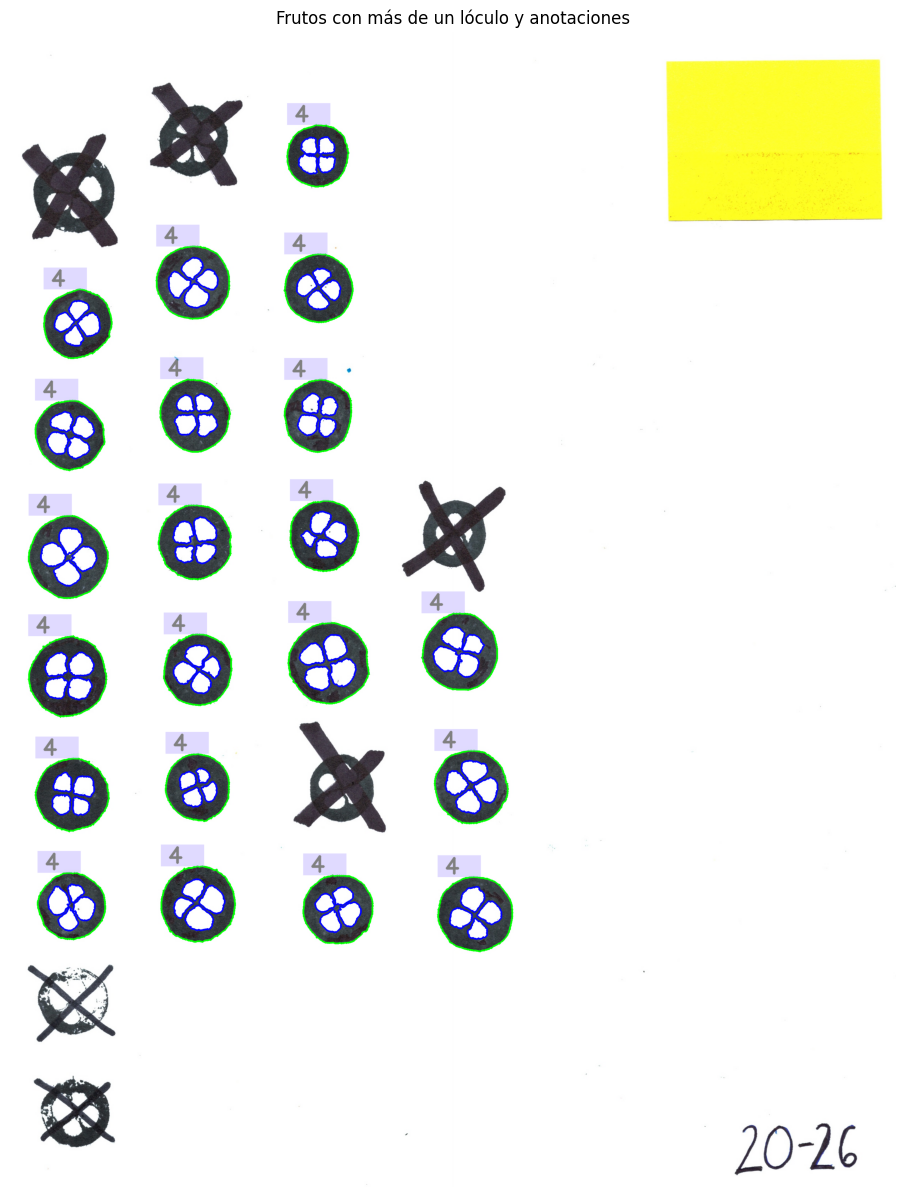

Imagen anotada guardada en: /Users/alejandra/Documents/GitHub/CranberryLab/External_structure/PDF/Stamp_photos/JPG/frutos_locus_anotados.png


In [ ]:

# Aplicar umbral para binarizar la imagen
_, binary = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)

# Aplicar cierre morfológico para rellenar huecos pequeños
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
closed_binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

# Encontrar contornos en la imagen cerrada
contours, hierarchy = cv2.findContours(closed_binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Crear una máscara vacía para rellenar contornos
filled_mask = np.zeros_like(closed_binary)
cv2.drawContours(filled_mask, contours, -1, (255), thickness=-1)

# Filtrar contornos padres basados en circularidad
def is_contour_bad(c, min_area=500, min_circularity=0.6, max_circularity=1.2):
    area = cv2.contourArea(c)
    perimeter = cv2.arcLength(c, True)
    if perimeter == 0:
        return True
    circularity = 4 * np.pi * (area / (perimeter * perimeter))
    return area < min_area or not (min_circularity <= circularity <= max_circularity)

filtered_contours = [
    i for i in range(len(contours))
    if hierarchy[0][i][3] == -1 and not is_contour_bad(contours[i])
]

# Detectar frutos y sus lóculos
fruit_locus_map = {}
for i in filtered_contours:
    fruit_locus_map[i] = []
    for j in range(len(contours)):
        if hierarchy[0][j][3] == i:
            fruit_locus_map[i].append(j)

# Filtrar lóculos muy pequeños
min_locus_area = 50
filtered_fruit_locus_map = {
    fruit_idx: [loculus_idx for loculus_idx in loculi if cv2.contourArea(contours[loculus_idx]) > min_locus_area]
    for fruit_idx, loculi in fruit_locus_map.items()
    if len(loculi) > 1  # Mantener solo padres con más de un contorno hijo
}

# Dibujar frutos, lóculos y anotaciones
image_with_contours = img.copy()

for fruit_idx, loculi in filtered_fruit_locus_map.items():
    # Dibujar contorno del fruto
    cv2.drawContours(image_with_contours, contours, fruit_idx, (0, 255, 0), 4)

    # Dibujar contornos de los lóculos asociados al fruto
    for loculus_idx in loculi:
        cv2.drawContours(image_with_contours, contours, loculus_idx, (255, 0, 0), 3)
    
    # Obtener la posición del fruto para anotar el número de lóculos
    x, y, w, h = cv2.boundingRect(contours[fruit_idx])
    num_loculi = len(loculi)

    # Crear una capa transparente para el rectángulo y el texto
    overlay = image_with_contours.copy()

    # Dibujar un rectángulo como fondo del texto en la capa transparente
    cv2.rectangle(
        overlay,
        (x, y - 60),  # Coordenadas superiores
        (x + 120, y),  # Coordenadas inferiores
        (255, 182, 193),  # Color rosa pastel
        -1  # Relleno completo
    )

    # Dibujar el texto en la capa transparente
    cv2.putText(
        overlay,
        f"{num_loculi}",
        (x + 20, y - 10),  # Coordenadas del texto
        cv2.FONT_HERSHEY_SIMPLEX,
        2,  # Tamaño de la fuente
        (0, 0, 0),  # Color negro
        6,  # Grosor del texto
        cv2.LINE_AA
    )

    # Combinar la capa con opacidad
    alpha = 0.5  # Nivel de opacidad
    cv2.addWeighted(overlay, alpha, image_with_contours, 1 - alpha, 0, image_with_contours)

# Mostrar la imagen final con anotaciones
plt.figure(figsize=(15, 15))
plt.imshow(cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB))
plt.title("Frutos con más de un lóculo y anotaciones")
plt.axis('off')
plt.show()

# Guardar la imagen anotada
output_path = "/Users/alejandra/Documents/GitHub/CranberryLab/External_structure/PDF/Stamp_photos/JPG/frutos_locus_anotados.png"
cv2.imwrite(output_path, image_with_contours)
print(f"Imagen anotada guardada en: {output_path}")


In [100]:
# Contar frutos (contornos externos) detectados después del filtrado
filtered_fruit_count = len(filtered_fruit_locus_map)
print(f"Número total de frutos detectados después del filtrado: {filtered_fruit_count}")


Número total de frutos detectados después del filtrado: 21


In [106]:
import pytesseract
from PIL import Image
import re

# Configurar la ruta de Tesseract en macOS
pytesseract.pytesseract.tesseract_cmd = "/opt/homebrew/bin/tesseract"

# Preprocesar la imagen para OCR
# Convertir a escala de grises
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Aplicar filtro de suavizado para reducir ruido
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Aplicar umbral adaptativo para mejorar el contraste
_, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Usar Tesseract para extraer texto
extracted_text = pytesseract.image_to_string(binary, lang='eng')

# Imprimir el texto detectado
print("Texto detectado en la imagen:")
print(extracted_text)




Texto detectado en la imagen:
20-26




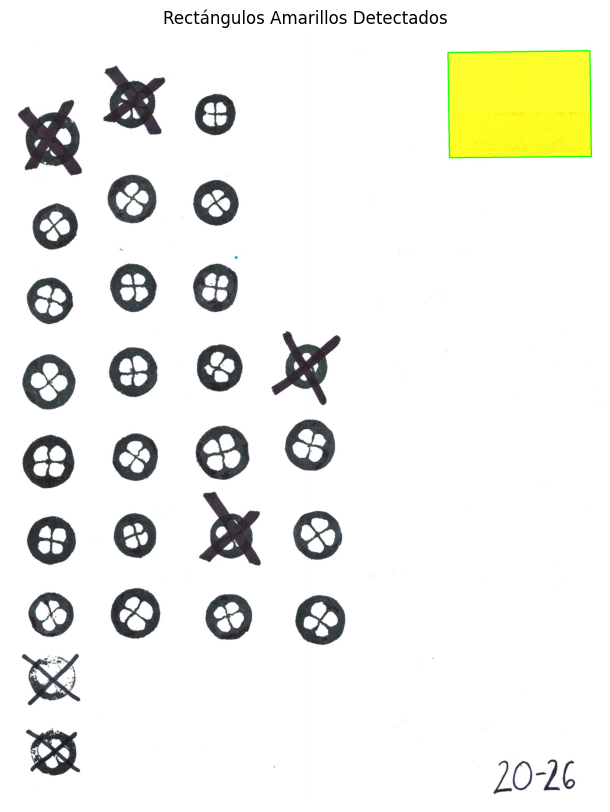

Imagen guardada en: /mnt/data/rectangulos_amarillos_detectados.png


In [116]:

# Convertir a espacio de color HSV para aislar el amarillo
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# Definir el rango de color amarillo en HSV
lower_yellow = np.array([20, 100, 100])
upper_yellow = np.array([30, 255, 255])

# Crear una máscara para el color amarillo
yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)

# Encontrar contornos en la máscara
contours, _ = cv2.findContours(yellow_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filtrar solo contornos rectangulares
rectangle_contours = []
for contour in contours:
    # Aproximar el contorno
    epsilon = 0.02 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)

    # Verificar si tiene 4 lados y es convexo
    if len(approx) == 4 and cv2.isContourConvex(approx):
        rectangle_contours.append(approx)

# Dibujar los rectángulos detectados en la imagen original
output_img = img.copy()
cv2.drawContours(output_img, rectangle_contours, -1, (0, 255, 0), 4)  # Verde para el contorno

# Mostrar la imagen con los rectángulos detectados
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
plt.title("Rectángulos Amarillos Detectados")
plt.axis('off')
plt.show()

# Guardar la imagen con los rectángulos detectados
output_path = "/mnt/data/rectangulos_amarillos_detectados.png"
cv2.imwrite(output_path, output_img)
print(f"Imagen guardada en: {output_path}")




In [117]:
# Detectar el texto usando OCR
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
_, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
extracted_text = pytesseract.image_to_string(binary, lang='eng').strip()
print(f"Texto extraído con OCR: {extracted_text}")

# Convertir la imagen a escala de grises para encontrar contornos
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Detectar el cuadrado amarillo para calcular escala
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
lower_yellow = np.array([20, 100, 100])
upper_yellow = np.array([30, 255, 255])
yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
contours, _ = cv2.findContours(yellow_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Encontrar el rectángulo amarillo más grande
largest_area = 0
reference_rect = None
for contour in contours:
    epsilon = 0.02 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    if len(approx) == 4 and cv2.isContourConvex(approx):
        area = cv2.contourArea(approx)
        if area > largest_area:
            largest_area = area
            reference_rect = cv2.boundingRect(approx)

# Calcular escala en píxeles/cm
if reference_rect:
    _, _, ref_width_px, ref_height_px = reference_rect
    ref_width_cm = 5.1  # Ancho en cm
    ref_height_cm = 3.8  # Alto en cm
    px_per_cm_x = ref_width_px / ref_width_cm
    px_per_cm_y = ref_height_px / ref_height_cm
else:
    raise ValueError("No se detectó el rectángulo amarillo para calcular la escala.")

# Procesar frutos y lóculos
_, binary = cv2.threshold(gray_img, 150, 255, cv2.THRESH_BINARY_INV)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
closed_binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
contours, hierarchy = cv2.findContours(closed_binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

def is_contour_bad(c, min_area=500, min_circularity=0.6, max_circularity=1.2):
    area = cv2.contourArea(c)
    perimeter = cv2.arcLength(c, True)
    if perimeter == 0:
        return True
    circularity = 4 * np.pi * (area / (perimeter * perimeter))
    return area < min_area or not (min_circularity <= circularity <= max_circularity)

filtered_contours = [
    i for i in range(len(contours))
    if hierarchy[0][i][3] == -1 and not is_contour_bad(contours[i])
]

fruit_locus_map = {}
for i in filtered_contours:
    fruit_locus_map[i] = []
    for j in range(len(contours)):
        if hierarchy[0][j][3] == i:
            fruit_locus_map[i].append(j)

min_locus_area = 50
filtered_fruit_locus_map = {
    fruit_idx: [loculus_idx for loculus_idx in loculi if cv2.contourArea(contours[loculus_idx]) > min_locus_area]
    for fruit_idx, loculi in fruit_locus_map.items()
    if len(loculi) > 1
}

# Calcular métricas de lóculos y convertir a cm
results = []
for fruit_id, loculi in filtered_fruit_locus_map.items():
    n_locules = len(loculi)
    if loculi:
        locule_areas_px = [cv2.contourArea(contours[locule]) for locule in loculi]
        locule_areas_cm = [area / (px_per_cm_x * px_per_cm_y) for area in locule_areas_px]
        locule_mean = np.mean(locule_areas_cm)
        locule_sd = np.std(locule_areas_cm, ddof=1)
        locule_cv = (locule_sd / locule_mean) * 100 if locule_mean != 0 else 0
    else:
        locule_mean = locule_sd = locule_cv = 0

    x, y, _, _ = cv2.boundingRect(contours[fruit_id])
    x_cm = x / px_per_cm_x
    y_cm = y / px_per_cm_y

    results.append({
        "ID_Fruit": fruit_id,
        "N_Locules": n_locules,
        "Mean_Area_cm2": locule_mean,
        "SD_Area_cm2": locule_sd,
        "CV_Area": locule_cv,
        "Position_X_cm": x_cm,
        "Position_Y_cm": y_cm,
        "Sample_ID": extracted_text
    })

# Guardar los resultados en un archivo CSV
output_csv = "/Users/alejandra/Documents/GitHub/CranberryLab/External_structure/PDF/Stamp_photos/JPG/results.csv"
with open(output_csv, mode="w", newline="") as file:
    writer = csv.DictWriter(file, fieldnames=["ID_Fruit", "N_Locules", "Mean_Area_cm2", "SD_Area_cm2", "CV_Area", "Position_X_cm", "Position_Y_cm", "Sample_ID"])
    writer.writeheader()
    writer.writerows(results)

print(f"Resultados guardados en: {output_csv}")


Texto extraído con OCR: 20-26
Resultados guardados en: /Users/alejandra/Documents/GitHub/CranberryLab/External_structure/PDF/Stamp_photos/JPG/results.csv


In [75]:
# Save locule statistics
# Crear una lista para almacenar los datos
results = []

# Procesar `fruit_locus_map` y calcular métricas adicionales para cada fruto
for fruit_id, loculi in filtered_fruit_locus_map.items():  # Usar `fruit_id` directamente de las claves del diccionario
    # Calcular el número de lóculos
    n_locules = len(loculi)

    # Calcular métricas (mean, SD, CV) si hay lóculos
    if loculi:
        locule_areas = [cv2.contourArea(contours[locule]) for locule in loculi]
        locule_mean = np.mean(locule_areas)
        locule_sd = np.std(locule_areas, ddof=1)
        locule_cv = (locule_sd / locule_mean) * 100 if locule_mean != 0 else 0
    else:
        locule_mean = 0
        locule_sd = 0
        locule_cv = 0

    # Obtener la posición del fruto a partir del índice en `fruit_id`
    # Convertir el fruit_id a un índice si es necesario o usa directamente el índice correspondiente
    index = fruit_id  # Usar directamente fruit_id como índice
    x, y, w, h = cv2.boundingRect(contours[index])  # Obtener las coordenadas de posición


    # Agregar los datos a la lista de resultados
    results.append({
        "ID_Fruit": fruit_id,  # Usar el ID original
        "N_Locules": n_locules,
        "Mean_Area": locule_mean,
        "SD_Area": locule_sd,
        "CV_Area": locule_cv,
        "Position_X": x,
        "Position_Y": y
    })

# Definir el nombre del archivo CSV de salida
output_csv = "numero_loculos_y_posicion_por_fruto.csv"

# Guardar los resultados en un archivo CSV
with open(output_csv, mode="w", newline="") as file:
    # Crear un escritor de CSV con los encabezados definidos
    writer = csv.DictWriter(file, fieldnames=["ID_Fruit", "N_Locules", "Mean_Area", "SD_Area", "CV_Area", "Position_X", "Position_Y"])
    
    # Escribir la fila de encabezado (columnas) en el archivo CSV
    writer.writeheader()
    
    # Escribir las filas de datos en el archivo
    writer.writerows(results)

# Imprimir un mensaje de confirmación
print(f"Resultados guardados en: {output_csv}")


Resultados guardados en: numero_loculos_y_posicion_por_fruto.csv


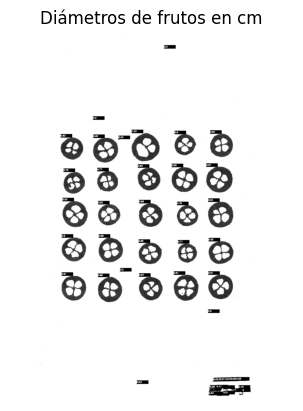

Imagen anotada guardada en: frutos_diametro_cm_anotados.png


In [80]:
# Definir la resolución en DPI (ajusta según la imagen)
dpi = 600  # Cambia este valor si tu resolución es diferente
pixels_per_cm = dpi / 2.54  # Píxeles por cm

# Dibujar frutos y anotar únicamente el diámetro en cm
image_with_contours = img.copy()

for fruit_idx, loculi in fruit_locus_map.items():
    # Obtener la posición del fruto y su ancho
    x, y, w, h = cv2.boundingRect(contours[fruit_idx])  # Coordenadas del rectángulo delimitador

    # Convertir el ancho del fruto a centímetros y redondear a dos decimales
    width_cm = round(w / pixels_per_cm, 2)

    # Asegurarse de que la posición del texto esté dentro de los límites de la imagen
    text_x = x
    text_y = max(y - 10, 10)  # Si y-10 es menor a 0, ajustar a 10

    # Dibuja un rectángulo como fondo del texto para mayor visibilidad
    cv2.rectangle(image_with_contours, (text_x, text_y - 20), (text_x + 100, text_y + 10), (0, 0, 0), -1)

    # Anotar únicamente el diámetro (ancho del fruto) en cm
    cv2.putText(
        image_with_contours,
        f"{width_cm}",  # Mostrar solo el número redondeado en cm
        (text_x, text_y),  # Posición del texto
        cv2.FONT_HERSHEY_SIMPLEX,  # Fuente del texto
        0.6,
        (255, 255, 255),  # Color del texto (blanco)
        2,  # Grosor del texto
        cv2.LINE_AA  # Tipo de línea
    )

# Mostrar la imagen con frutos y diámetros en cm anotados
plt.imshow(cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB))
plt.title("Diámetros de frutos en cm")
plt.axis('off')
plt.show()

# Guardar la imagen anotada
output_path = "frutos_diametro_cm_anotados.png"
cv2.imwrite(output_path, image_with_contours)
print(f"Imagen anotada guardada en: {output_path}")


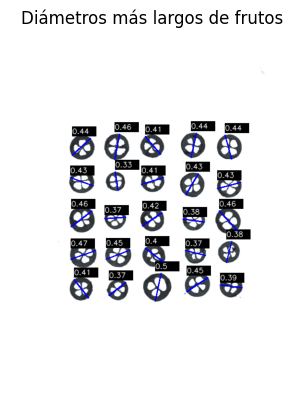

Imagen anotada guardada en: frutos_diametro_largo_anotados.png


In [179]:
# Dibujar frutos con el diámetro más largo y anotarlo
image_with_contours = img.copy()

for fruit_idx, loculi in fruit_locus_map.items():
    # Obtener los puntos del contorno del fruto
    contour = contours[fruit_idx]
    
    # Encontrar la distancia máxima entre dos puntos del contorno (diámetro más largo)
    max_dist = 0
    start_point = (0, 0)
    end_point = (0, 0)
    for i in range(len(contour)):
        for j in range(i + 1, len(contour)):
            dist = cv2.norm(contour[i][0] - contour[j][0])  # Calcular la distancia entre puntos
            if dist > max_dist:
                max_dist = dist
                start_point = tuple(contour[i][0])
                end_point = tuple(contour[j][0])

    # Convertir el diámetro a cm y redondear
    diameter_cm = round(max_dist / pixels_per_cm, 2)

    # Dibujar la línea del diámetro más largo
    cv2.line(image_with_contours, start_point, end_point, (255, 0, 0), 2)  # Línea azul de grosor 2

    # Anotar el diámetro encima del fruto
    text_x = min(start_point[0], end_point[0])  # Elegir la coordenada x menor para colocar el texto
    text_y = min(start_point[1], end_point[1]) - 10  # Ajustar para colocar encima
    text_y = max(text_y, 10)  # Asegurarse de que el texto no salga de la imagen
    cv2.rectangle(image_with_contours, (text_x, text_y - 15), (text_x + 50, text_y + 5), (0, 0, 0), -1)  # Fondo negro
    cv2.putText(
        image_with_contours,
        f"{diameter_cm}",  # Texto con el diámetro en cm
        (text_x, text_y),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,  # Tamaño de la fuente
        (255, 255, 255),  # Color del texto (blanco)
        1,  # Grosor de la fuente
        cv2.LINE_AA
    )

# Mostrar la imagen con frutos y diámetros más largos anotados
plt.imshow(cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB))
plt.title("Diámetros más largos de frutos")
plt.axis('off')
plt.show()

# Guardar la imagen anotada
output_path = "frutos_diametro_largo_anotados.png"
cv2.imwrite(output_path, image_with_contours)
print(f"Imagen anotada guardada en: {output_path}")
